In [344]:
from scipy.stats import fisher_exact
import pandas as pd
import copy
import json
import gzip
import requests
import sys
import matplotlib.pyplot as plt
from Bio import SeqIO


In [345]:
Doid_obo = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/doid.obo"

In [346]:
# Load DO ontology and parse
with open(Doid_obo) as do_ontology:
    labels, ancestors, min_depth = disease_ontology(do_ontology)

In [347]:
Do_Uniprot = 'C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets//uniprot_do5.json'

In [348]:
# Load DO on humans (DOA)
with open(Do_Uniprot) as file:
    protein_to_do = json.load(file)


In [288]:
def disease_ontology(do_ontology):

    do = {}  # { do_id : do_object }
    obj = {}  # { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True } 
    for line in do_ontology:
        line = line.strip().split(": ")
        if line and len(line) == 2:
            k, v = line
            if k == "id" and v.startswith("DOID:"):
                obj["id"] = v.split(":")[1]
            elif k == "xref" and "OMIM" in v:
                obj["omim"] = v.split(":")[1]
            elif k == "name":
                obj["name"] = v
            elif k == "is_a":
                obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
            elif k == "is_obsolete":
                obj["is_obsolete"] = True
        else:
            if obj.get("id") and not obj.get("is_obsolete"):
                do[obj["id"]] = obj
            obj = {}
        
    # compute the dictionary of ancestors and depth for each node
    labels, ancestors, depth = ancestors(do)
    
    return labels, ancestors, depth


In [349]:
def ancestors(do):
    """
    Retrive ancestors dict and depth dict for each node
    """

    ancestors = {}  # { term : list_of_ancestor_terms }
    parents = {}
    depth = {}
    labels = {}
    for node in do:
        c = 0
        node_ancestors = []
        node_parents = do[node].get("is_a")
        labels[node] = do[node].get("name")
        if node_parents != None:
            parents[node] = node_parents
        else:
            parents[node] = []
        # Loop parent levels until no more parents
        while node_parents:
            c += 1
            node_ancestors.extend(node_parents)
            if "4" in node_parents:  # "4" is the root ID
                depth[node] = c
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in do[parent].get("is_a", [])]
        ancestors[node] = set(node_ancestors)
    # recompute depth... we are having some problems with this one
    depth = min_depth(list(do.keys()), parents)
     
    return labels, ancestors, depth

In [350]:
def min_depth(nodes, parents):   
    """
    Calculate the minimum depth (distance from the root) of each term
    """
    depth = {}  # { term : min_depth }
    # get list of roots
    roots = set(nodes) - set(parents.keys())
    for node in nodes:
        c = 0  # Depth level
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            if roots.intersection(set(node_parents)):  # break the loop if the root is among parents
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth


In [351]:
def fisher_test(d_count, bg_count, depth, l):
    """
    Perform a fisher exact test 
    """

    # Init result dict
    results = {}
    
    # Get the tot number of counts
    tot_d = sum(list(d_count.values()))
    tot_bg = sum(list(bg_count.values()))
    
    key_intersection = set(d_count.keys()).intersection(set(bg_count.keys()))
    
    for key in key_intersection:
        # Number of occurrences of the specific GO term in d_count   
        a = d_count[key]
        # Number of occurrences of the specific GO term in bg_count
        b = bg_count[key]
        # Number of GO terms that are different from the specific one in d_count
        not_a = tot_d - a
        # Number of GO terms that are different from the specific one in bg_count
        not_b = tot_bg - b
        
        # Perform Fisher Exact Test
        fisher_results = fisher_exact([[a, b],[not_a, not_b]])
        
        # Create dataframe with results
        results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})
    
    # Return the DataFrame
    return pd.DataFrame(results).transpose()


def add_depth_description(df, min_depth, labels):
    """
    Add depth and description columns to the dataframe
    """
    labels_list, min_depth_list = [], []
    for key in df.index:
        labels_list.append(labels[key])
        min_depth_list.append(min_depth[key])
    
    df['depth'] = min_depth_list
    df['label'] = labels_list

    return df

In [352]:
from wordcloud import WordCloud, get_single_color_func
import matplotlib.pyplot as plt
import pandas as pd


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color="grey"):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.
       Uses wordcloud.get_single_color_func
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color = "grey"):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


def draw_word_cloud(df, score='OddRatio', N=20, N_under_represented=0, under_represented=False, scale=2.0):
    """
    Draw first and last N descriptions of df
    Scale less abboundant terms by a factor scale
    """
    if under_represented:
        # draw also underepresented words
        head, tail = df[:N].copy(), df[-N_under_represented:].copy()
        
        # invert score of tail dataframe
        tail[score] = 1 / tail[score] * scale
        
        df_draw = pd.concat([head,tail], ignore_index=True)
    else:
        df_draw = df[:N]
    
    wc = WordCloud(background_color='white', width=800, height=800, max_words=100, collocations=False)
    wc.generate_from_frequencies(
        {line['label']: line[score] for _, line in df_draw.iterrows()}
    )

    if under_represented:
        color_to_words = {
            '#ff7f0e' : head['label'].to_list(),
            '#1f77b4' : tail['label'].to_list()
        }
        # Create a color function with single tone
        grouped_color_func = SimpleGroupedColorFunc(color_to_words)

        # Apply our color function
        wc.recolor(color_func=grouped_color_func)

        return wc
    
    else:
        return wc
    

In [353]:
def count_ancestors(protein_list, ancestors, protein_to_go):
    """
    Count the ancestors for a list of proteins
    """
    counts = {}

    # the intersection between protein_list and protein_to_go.keys
    # is needed since not all human proteins are annotated
    for protein in set(protein_list).intersection(set(protein_to_go.keys())):
        annotations = set(protein_to_go[protein])

        terms_ancestors = copy.copy(annotations)  # annotations + ancestor terms
        for term in annotations:  # directly annotated terms
            terms_ancestors.update(set(ancestors.get(term, [])))  # add ancestors
        for term in terms_ancestors:
            counts.setdefault(term, 0)
            counts[term] += 1
        
    return counts

In [354]:
#A: ORIGINAL DATASET VS SWISSPROT HUMAN PROTEOME

In [355]:

Original = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/Original_dataset5.txt"

# Read the original dataset (hits retrieved by our model)
with open(Original) as f:
    dataset = f.read().splitlines()

In [296]:

# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/uniprot-reviewed_Homo_sapiens.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [297]:
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(background, ancestors, protein_to_do)

In [298]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [299]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

result_fisher.head()

,OddRatio,p-value
2247,310.846821,0.006412
0080010,310.846821,0.006412
0080325,103.614644,0.012784
4990,77.710621,0.015954
0050678,62.168208,0.019114


In [300]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
2247,310.846821,0.006412,7,spondylosis
0080010,310.846821,0.006412,6,bone structure disease
0080325,103.614644,0.012784,6,tuberous sclerosis 2
4990,77.710621,0.015954,6,essential tremor
0050678,62.168208,0.019114,5,Blau syndrome


In [301]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.00026455026455026457


In [302]:
# filter by depth
filter_terms = (result["depth"] <= 5) & (result["p-value"] <= alpha)

result[filter_terms].head()

,OddRatio,p-value,depth,label
0050678,62.168208,0.019114,5,Blau syndrome
0050855,23.909960,0.044033,4,renal fibrosis
0050830,4.797298,0.010827,5,peripheral artery disease
3393,4.299282,0.007109,5,coronary artery disease
0050828,2.459944,0.039048,4,artery disease


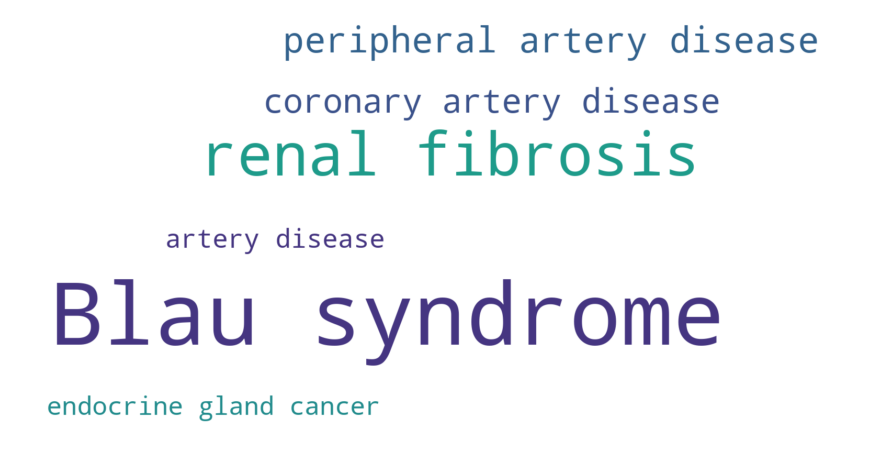

In [303]:
N = 50

wc = draw_word_cloud(
    df = result[filter_terms],
    N = N,
    score = 'OddRatio',
    under_represented = False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


In [304]:
#B: Architectures datasets - The original dataset

In [305]:
# file containing architectures datasets

# read architecture
with open("C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/architecture_datasets.json") as f:
    arch_dataset = json.load(f)

In [306]:
for key in arch_dataset:
    print(arch_dataset[key])

['Q68DX3']
['Q9HAP6']
['Q8TBB1']
['Q76G19', 'Q9H6Y5', 'Q6IN97', 'P57105', 'Q8N448', 'Q9Y6N9', 'O15018', 'Q14005', 'Q9UPQ7', 'Q6ZMN7', 'Q8IXQ8']
['Q96QZ7']
['O95049', 'Q9UDY2']
['A8MUH7', 'Q9C0E4', 'Q86UT5', 'Q5T2W1']
['P83110', 'Q92743']
['Q5TCQ9', 'Q86UL8']
['O15085']
['P83105']
['Q6ZWJ1']
['Q96RT1', 'Q96NW7']
['Q96JY6']
['Q8TEW0', 'Q8TEW8']
['P78352']
['Q14168', 'Q9NZW5']
['Q9P227']
['Q15700']
['Q8NI35']
['Q14CM0', 'Q5JV73']
['Q15599']
['Q8NEN9']
['Q9NZN5']
['Q12959']
['Q07157']
['O14745']
['O75970']
['Q92796']
['P26045', 'Q12923']
['O43464']


In [307]:

Original = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/Original_dataset5.txt"

# Read the original dataset (hits retrieved by our model)
with open(Original) as f:
    dataset = f.read().splitlines()

In [308]:
# count the anchestors for each sequence of the dataset
background_count = count_ancestors(dataset, ancestors, protein_to_do)

In [325]:
# create a list of df, in each one of them there is the results

# consider only datasets containing at least MIN_SIZE sequences
MIN_SIZE = 2 #???

results = {}
filtered_results = {}

for key in arch_dataset:
    
    current_dataset = arch_dataset[key]
    
    if len(current_dataset) >= MIN_SIZE:
        print("Number of sequences in the current dataset: {}".format(
            len(current_dataset))
             )
    
        dataset_count = count_ancestors(current_dataset, ancestors, protein_to_do)

        # perform fisher exact test
        result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)
        result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

        # add depth and description columns
        result = add_depth_description(
            df = result_fisher,
            min_depth = min_depth, 
            labels = labels )

        results[key] = result
        
        alpha = 0.1
        
        # filter by depth
        filter_terms = (result["p-value"] <= alpha)
        filtered_results[key] = result[filter_terms]

Number of sequences in the current dataset: 11
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 4
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 2
Number of sequences in the current dataset: 2


In [326]:
for key in filtered_results:
    print(filtered_results[key])

Empty DataFrame
Columns: [OddRatio, p-value, depth, label]
Index: []
Empty DataFrame
Columns: [OddRatio, p-value, depth, label]
Index: []
       OddRatio   p-value  depth                              label
14566    5.8125  0.028068      1  disease of cellular proliferation
162      5.8125  0.028068      2                             cancer
4        5.4000  0.033322      0                            disease
Empty DataFrame
Columns: [OddRatio, p-value, depth, label]
Index: []
Empty DataFrame
Columns: [OddRatio, p-value, depth, label]
Index: []
Empty DataFrame
Columns: [OddRatio, p-value, depth, label]
Index: []
Empty DataFrame
Columns: [OddRatio, p-value, depth, label]
Index: []
       OddRatio   p-value  depth                   label
8029  23.066667  0.083859      7  sporadic breast cancer
          OddRatio   p-value  depth                                    label
1059     31.409091  0.050270      4                  intellectual disability
0060038  31.409091  0.050270      3          s

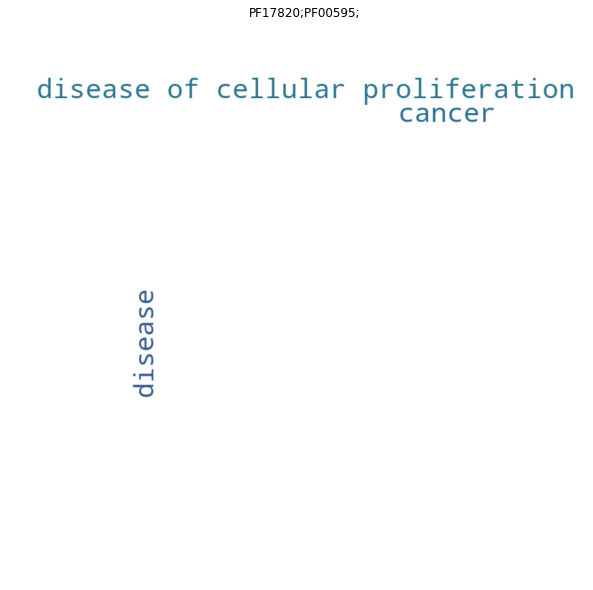

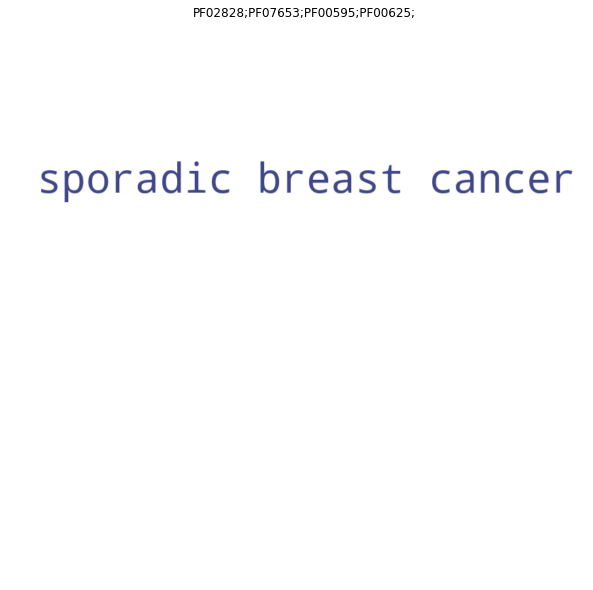

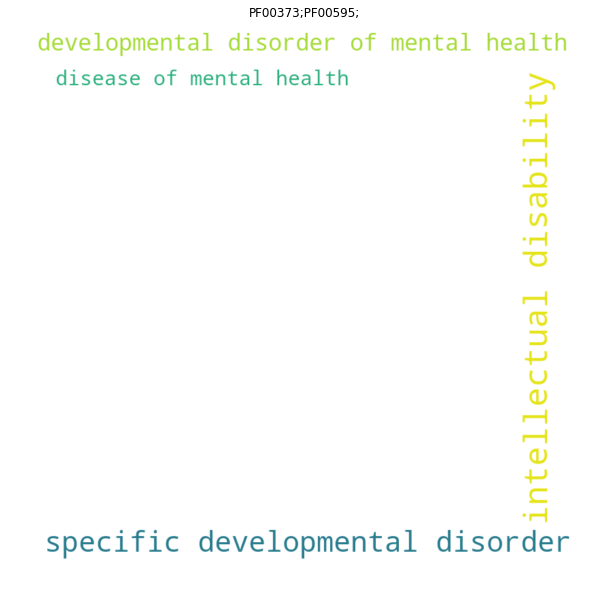

In [329]:
# draw wordcloud
for key in filtered_results:
    
    if filtered_results[key].shape[0] > 0:
    
        # Num of words to be drawn
        N = sum(filtered_results[key].OddRatio > 0)
        wc = draw_word_cloud(
            df = filtered_results[key],
            N = N,
            score = 'OddRatio',
            under_represented=False
        )

        # Plot
        plt.figure(figsize=(10, 10))
        plt.title(key)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [235]:
#C:PDB network - All human PDB proteins available in SwissProt (intersection).

In [236]:

PDB_PATH= "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/PDB_dataset.txt"
dataset_df = pd.read_csv(PDB_PATH,header=None,names=["sp_primary"])
dataset_df.head()


,sp_primary
0,Q6PIF6
1,P53778
2,P07355
3,Q8NEN9
4,Q16348


In [237]:
# get the list (unique) of proteins
dataset = dataset_df.sp_primary.unique()
print("There are {} proteins in the original dataset with a PDB \n \
      + other human proteins wich are found as other chains in the same PDB ".format(len(dataset)))

There are 79 proteins in the original dataset with a PDB 
       + other human proteins wich are found as other chains in the same PDB 


In [238]:
# datasate with human sequences in swissprot
#PATH_REFERENCE_DB = '../../data/SwissProt_humans_reference_all.fasta'
human = 'C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/uniprot-reviewed_Homo_sapiens.fasta'

In [239]:
###building intersection

In [240]:
def getListHumans(path):
    """
    Return the list of human sequences in swissprot
    """
    human = SeqIO.parse(path, 'fasta')
    list_human = []
    for sequence in human:
        name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
        list_human.append(name.split('|')[1])

    print('There are {} human proteins in SwissProt'.format(len(list_human)))
    return list_human





In [241]:
list_human = getListHumans(human)


There are 20367 human proteins in SwissProt


In [242]:
Original = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/Original_dataset5.txt"

# Import original dataset
original_proteins = []
with open(Original) as file:
    for line in file:
        original_proteins.append(line.strip())

In [243]:
PDB_UNIPROT_DS = "C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/pdb_chain_uniprot_5.csv"
#colnames=['PDB', 'CHAIN', 'SP_PRIMARY', 'RES_BEG', "RES_END", "PDB_BEG", "PDB_END", "SP_BEG","SP_END"] 

# Import pdb - uniprot relation file
pdb_rel = pd.read_csv(PDB_UNIPROT_DS,header=0)
pdb_rel=pd.DataFrame(pdb_rel)
pdb_rel.columns = list(map(lambda x: x.lower(), pdb_rel.columns.values))



In [244]:
pdb_rel.head()

,pdb,chain,sp_primary,res_beg,res_end,pdb_beg,pdb_end,sp_beg,sp_end
0,101m,A,P02185,1,154,0,153,1,154
1,102l,A,P00720,1,40,1,40,1,40
2,102l,A,P00720,42,165,41,None,41,164
3,102m,A,P02185,1,154,0,153,1,154
4,103l,A,P00720,1,40,1,None,1,40


In [245]:
# Create background dataframe, all PDB proteins in swissprot
pdb_bg_df = pdb_rel.loc[
    pdb_rel.sp_primary.isin(list_human),
    ['pdb','sp_primary','chain','sp_beg','sp_end']
].copy()

In [246]:
bg_dataset = pdb_bg_df.sp_primary.unique()
print("There are {} human PDB proteins in Swissprot".format(len(bg_dataset)))

There are 6742 human PDB proteins in Swissprot


In [247]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [248]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [249]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)


In [250]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0080010,97.866412,0.020146,6,bone structure disease
2059,97.866412,0.020146,4,vulvar disease
1294,97.866412,0.020146,7,vulva carcinoma
0080366,97.866412,0.020146,6,desmoid tumor
1245,97.866412,0.020146,6,vulva cancer


In [251]:
# Bonferroni correction
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 0.0002109704641350211


In [252]:
# filter by depth and pvalue
filter_terms = (result["depth"] <= 5) & (result["p-value"] <= 0.05)
result[filter_terms].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2059 to 225
Data columns (total 4 columns):
OddRatio    17 non-null float64
p-value     17 non-null float64
depth       17 non-null int64
label       17 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 680.0+ bytes


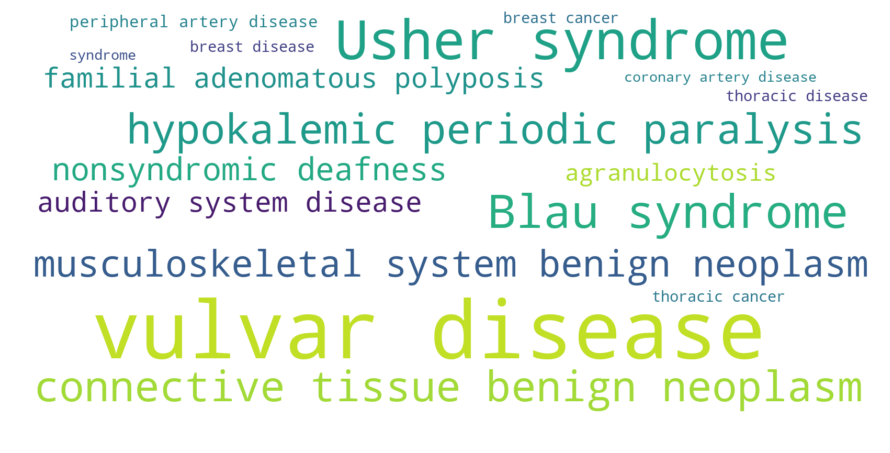

In [253]:
# Num of words to be drawn
N = 17

wc = draw_word_cloud(
    df = result[filter_terms],
    N = N,
    score = 'OddRatio',
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [254]:
#D: STRING network - All human proteins available in STRING and SwissProt (intersection)

In [334]:
# read the STRING dataset (proteins of the original dataset + all direct STRING interactors)
with open("C:/Users/Hp/Desktop/Data Science/Third Semester/Bioligical Data/Project/BiologicalData-master/datasets/NEW_STRING_dataset.txt") as f:
    dataset = f.read().splitlines()
print("There are {} proteins in the STRING dataset".format(len(dataset)))

There are 437 proteins in the STRING dataset


In [335]:
###Background dataset:
import requests

URL = "https://www.uniprot.org"

# All human proteins available in STRING and Swissprot
query = "database:(type:string) AND reviewed:yes AND organism:\"Homo sapiens (Human) [9606]\"&format=list"
r = requests.get("{}/uniprot/?query={}".format(URL, query))

In [336]:
bg_dataset = r.text.strip().split("\n")
print("There are {} human proteins available in STRING and Swissprot".format(len(bg_dataset)))

There are 18561 human proteins available in STRING and Swissprot


In [337]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_do)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_do)

In [338]:
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)


In [339]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)


In [340]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0050678,28.735892,0.000009,5,Blau syndrome
13619,28.724157,0.006493,7,extrahepatic cholestasis
0060082,28.720248,0.066171,5,breast benign neoplasm
4556,28.720248,0.066171,8,lung large cell carcinoma
0110368,28.720248,0.066171,9,retinitis pigmentosa 26


In [341]:
# Bonferroni correction
alpha = 0.05
m = result.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 7.215007215007215e-05


In [342]:
# filter by depth
filter_terms = (result["depth"] <= 6) 
#filter_terms = result_fisher["p-value"] <= 0.1
result[filter_terms].head()

,OddRatio,p-value,depth,label
0050678,28.735892,0.000009,5,Blau syndrome
0060082,28.720248,0.066171,5,breast benign neoplasm
11330,28.720248,0.066171,5,erysipelas
0080109,28.720248,0.066171,6,infantile myofibromatosis
7475,28.720248,0.066171,4,diverticulitis


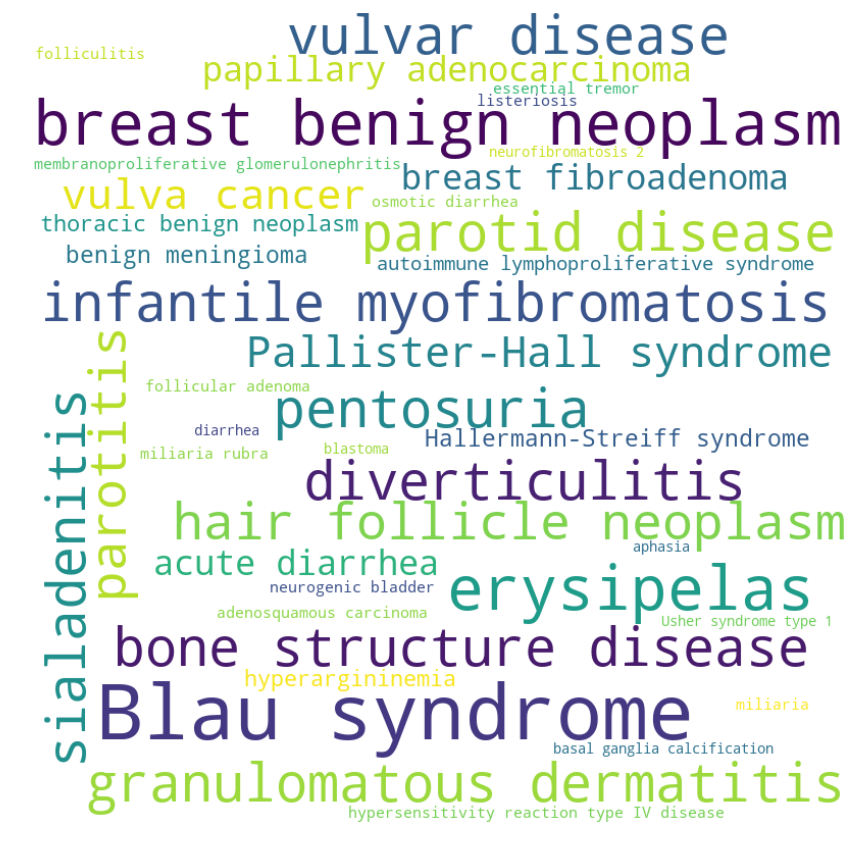

In [343]:
# max num of words to be drawn
N_max = 40

wc = draw_word_cloud(
    df = result[filter_terms],
    N = sum(result[filter_terms][:N_max].OddRatio > 0.5),
    #N_under_represented = sum(result[filter_terms][-N_max:].OddRatio < 1),
    score = 'OddRatio',
    scale = 1,
    under_represented=False
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


